In [1]:
import time
import math
from functools import partial
from tqdm.auto import tqdm
from tqdm.utils import _term_move_up

prefix = _term_move_up() + '\r'

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# from mamba import Mamba, MambaConfig
from mamba_ssm import Mamba
# from mamba_ssm.modules.mamba_simple import Block
from mamba_ssm.models.mixer_seq_simple import create_block, _init_weights

from transformers import get_cosine_schedule_with_warmup

from data import DrawingDataset
from customModel import customModel

%load_ext autoreload
%autoreload 2

2024-03-08 16:19:11.542600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 16:19:12.152634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_properties(0))

True
NVIDIA GeForce GTX 1080
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8110MB, multi_processor_count=20)


In [3]:
batch_size = 64
max_length = 100

train_dataset = DrawingDataset(data_path="./data", split="train", max_length=max_length)
val_dataset = DrawingDataset(data_path="./data", split="valid", max_length=max_length)
test_dataset = DrawingDataset(data_path="./data", split="test", max_length=max_length)

train = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

['./data/The Eiffel Tower.npz', './data/The Great Wall of China.npz', './data/The Mona Lisa.npz', './data/aircraft carrier.npz', './data/airplane.npz', './data/alarm clock.npz', './data/ambulance.npz', './data/angel.npz', './data/animal migration.npz', './data/ant.npz', './data/anvil.npz', './data/apple.npz', './data/arm.npz', './data/asparagus.npz', './data/axe.npz', './data/backpack.npz', './data/banana.npz', './data/bandage.npz', './data/barn.npz', './data/baseball bat.npz', './data/baseball.npz', './data/basket.npz', './data/basketball.npz', './data/bat.npz', './data/bathtub.npz', './data/beach.npz', './data/bear.npz', './data/beard.npz', './data/bed.npz', './data/bee.npz', './data/belt.npz', './data/bench.npz', './data/bicycle.npz', './data/binoculars.npz', './data/bird.npz', './data/birthday cake.npz', './data/blackberry.npz', './data/blueberry.npz', './data/book.npz', './data/boomerang.npz', './data/bottlecap.npz', './data/bowtie.npz', './data/bracelet.npz', './data/brain.npz', 

  0%|          | 0/345 [00:00<?, ?it/s]

  0%|          | 1/345 [00:00<02:55,  1.96it/s]


['./data/The Eiffel Tower.npz', './data/The Great Wall of China.npz', './data/The Mona Lisa.npz', './data/aircraft carrier.npz', './data/airplane.npz', './data/alarm clock.npz', './data/ambulance.npz', './data/angel.npz', './data/animal migration.npz', './data/ant.npz', './data/anvil.npz', './data/apple.npz', './data/arm.npz', './data/asparagus.npz', './data/axe.npz', './data/backpack.npz', './data/banana.npz', './data/bandage.npz', './data/barn.npz', './data/baseball bat.npz', './data/baseball.npz', './data/basket.npz', './data/basketball.npz', './data/bat.npz', './data/bathtub.npz', './data/beach.npz', './data/bear.npz', './data/beard.npz', './data/bed.npz', './data/bee.npz', './data/belt.npz', './data/bench.npz', './data/bicycle.npz', './data/binoculars.npz', './data/bird.npz', './data/birthday cake.npz', './data/blackberry.npz', './data/blueberry.npz', './data/book.npz', './data/boomerang.npz', './data/bottlecap.npz', './data/bowtie.npz', './data/bracelet.npz', './data/brain.npz', 

  0%|          | 1/345 [00:00<00:06, 51.89it/s]


['./data/The Eiffel Tower.npz', './data/The Great Wall of China.npz', './data/The Mona Lisa.npz', './data/aircraft carrier.npz', './data/airplane.npz', './data/alarm clock.npz', './data/ambulance.npz', './data/angel.npz', './data/animal migration.npz', './data/ant.npz', './data/anvil.npz', './data/apple.npz', './data/arm.npz', './data/asparagus.npz', './data/axe.npz', './data/backpack.npz', './data/banana.npz', './data/bandage.npz', './data/barn.npz', './data/baseball bat.npz', './data/baseball.npz', './data/basket.npz', './data/basketball.npz', './data/bat.npz', './data/bathtub.npz', './data/beach.npz', './data/bear.npz', './data/beard.npz', './data/bed.npz', './data/bee.npz', './data/belt.npz', './data/bench.npz', './data/bicycle.npz', './data/binoculars.npz', './data/bird.npz', './data/birthday cake.npz', './data/blackberry.npz', './data/blueberry.npz', './data/book.npz', './data/boomerang.npz', './data/bottlecap.npz', './data/bowtie.npz', './data/bracelet.npz', './data/brain.npz', 

  0%|          | 1/345 [00:00<00:08, 41.99it/s]


In [9]:
log_interval = 25
epochs = 10

batches = len(train)

model = customModel(nb=4, no=2, ns=2, embed_dim=256).to("cuda")

offset_crit = nn.MSELoss(reduction='none')
state_crit = nn.CrossEntropyLoss()

#optimizer = torch.optim.RAdam(model.parameters(), lr=5e-4)
warmup_ratio = 0.03

print(0.05 * math.sqrt(batch_size / (batches * epochs)))
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, betas=(0.99, 0.95), eps=1e-4,
                              weight_decay=0.05 * math.sqrt(batch_size / (batches * epochs)))   
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=1,
                                            num_training_steps=epochs)

writer = SummaryWriter('./logs')

def train_model(model, data_loader, optimizer, epoch):
    model.train()
    
    size = len(data_loader)
    
    # Total Losses
    total_loss = 0
    total_offset_loss = 0
    total_state_loss = 0
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    running_correct = 0
    running_total = 0
    
    running_mse = 0
    
    start_time = time.time()
    
    for i, data in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()
        
        inputs, targets = data
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")
        
        offsets, states = model(inputs)
        
        # Split Target
        offset_target = targets[:, :, :2]
        state_target = targets[:, :, 2:].argmax(dim=-1)
        no_pad_mask = state_target != 2
        
        # Masked MSE Loss for offset
        offset_loss = offset_crit(offsets, offset_target)
        offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
        
        offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
        
        # Cross Entropy Loss for State
        state_loss = state_crit(states.transpose(1, 2), state_target)
        loss = offset_loss + state_loss
        
        # Calculate other metrics (accuracy)
        with torch.no_grad():
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = state_target.flatten() != 2

            running_correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            running_total += states_pred.flatten()[no_pad_mask].size().numel()
            
            flat_offsets_pred = offsets.reshape(-1, 2)[no_pad_mask, :]
            flat_offset_target = targets[:, :, :2].reshape(-1, 2)[no_pad_mask, :]
            running_mse += nn.functional.mse_loss(flat_offsets_pred, flat_offset_target)
        
        # Backprop
        loss.backward(retain_graph=True)
        
        # Gradient Clipping
        for name, param in model.named_parameters():
            torch.nn.utils.clip_grad_norm_(param, max_norm=1.5)
        
        # Optimizer Steps
        optimizer.step()
        
        running_loss += loss.item()
        running_offset_loss += offset_loss.item()
        running_state_loss += state_loss.item()
        
        total_loss += loss.item()
        total_offset_loss += offset_loss.item()
        total_state_loss += state_loss.item()
        
        # Print speed, losses, and accuracy every 25 batchs
        if i % log_interval == 0 and i > 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = running_loss / log_interval
            cur_offset_loss = running_offset_loss / log_interval
            cur_state_loss = running_state_loss / log_interval
            cur_accuracy = running_correct / running_total
            cur_mse = running_mse / log_interval
            tqdm.write(f'{prefix}| epoch {(epoch+1):3d} | {i:5d}/{size:5d} batches '
                  f'| ms/batch {ms_per_batch:5.2f} | '
                  f'offset_loss {cur_offset_loss:5.2f} | state_loss {cur_state_loss:5.4f} | '
                  f'accuracy {cur_accuracy:5.4f} | mse {cur_mse:5.2f}')
            time.sleep(0)
            running_loss = 0
            running_offset_loss = 0
            running_state_loss = 0
            running_correct = 0
            running_total = 0
            running_mse = 0
            start_time = time.time()
    
    return total_loss / size, total_offset_loss / size, total_state_loss / size
        
def evaluate_model(model, data_loader):
    model.eval()
    size = len(data_loader)
    
    # Running Losses
    running_loss = 0
    running_offset_loss = 0
    running_state_loss = 0
    
    # Correct
    correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs, targets = data
            inputs = inputs.to("cuda")
            targets = targets.to("cuda")
            
            offsets, states = model(inputs)
            
            # Masked MSE Loss
            offset_target = targets[:, :, :2]
            state_target = targets[:, :, 2:].argmax(dim=-1)
            no_pad_mask = state_target != 2
            
            offset_loss = offset_crit(offsets, offset_target)
            offset_loss_mask = offset_loss * no_pad_mask.unsqueeze(-1).float()
            offset_loss = offset_loss_mask.sum() / no_pad_mask.sum()
            
            state_loss = state_crit(states.transpose(1, 2), state_target)
            loss = offset_loss + state_loss
            
            # Accuracy Calculation
            states_softmax = torch.nn.functional.softmax(states, dim=-1)
            states_pred = states_softmax.argmax(dim=-1)
            
            no_pad_mask = no_pad_mask.flatten()
            
            correct += (states_pred.flatten()[no_pad_mask] == state_target.flatten()[no_pad_mask]).sum().item()
            total_samples += states_pred.flatten()[no_pad_mask].size().numel()
            
            running_loss += loss.item()
            running_offset_loss += offset_loss.item()
            running_state_loss += state_loss.item()
    
    return running_loss / size, running_offset_loss / size, running_state_loss / size, correct / total_samples
            


0.004042673293062811


In [10]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train_loss, train_offset_loss, train_state_loss = train_model(model, train, optimizer, epoch)
    print(f"Training: Epoch: {epoch+1}, offset_loss: {train_offset_loss:5.4f}, state_loss: {train_state_loss:5.4f}")
    writer.add_scalar("Train/Loss/Epoch", train_loss, epoch)
    writer.add_scalar("Train/Offset_Loss/Epoch", train_offset_loss, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", train_state_loss, epoch)
    
    val_loss, val_offset_loss, val_state_loss, val_accuracy = evaluate_model(model, val)
    print(f"Validation: Epoch: {epoch+1}, offset_loss: {val_offset_loss:5.2f}, state_loss: {val_state_loss:5.4f}, accuracy: {val_accuracy:5.4f}")
    writer.add_scalar("Train/Loss/Epoch", val_loss, epoch)
    writer.add_scalar("Train/Offset_Loss/Epoch", val_offset_loss, epoch)
    writer.add_scalar("Train/State_Loss/Epoch", val_state_loss, epoch)
    
    scheduler.step()

  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   1 |   975/  979 batches | ms/batch 135.17 | offset_loss 3500.68 | state_loss 1.0961 | accuracy 0.6347 | mse 1750.34
Training: Epoch: 1, offset_loss: 3496.2877, state_loss: 1.0961


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 1, offset_loss: 3543.78, state_loss: 1.0964, accuracy: 0.6022


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   2 |   975/  979 batches | ms/batch 139.68 | offset_loss 1838.56 | state_loss 0.2427 | accuracy 0.8538 | mse 919.288
Training: Epoch: 2, offset_loss: 2596.0839, state_loss: 0.2922


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 2, offset_loss: 1632.14, state_loss: 0.2354, accuracy: 0.8568


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   3 |   975/  979 batches | ms/batch 142.35 | offset_loss 1762.67 | state_loss 0.2371 | accuracy 0.8561 | mse 881.33
Training: Epoch: 3, offset_loss: 1762.3638, state_loss: 0.2413


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 3, offset_loss: 1504.01, state_loss: 0.2256, accuracy: 0.8597


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   4 |   975/  979 batches | ms/batch 138.16 | offset_loss 1632.56 | state_loss 0.2301 | accuracy 0.8618 | mse 816.28
Training: Epoch: 4, offset_loss: 1652.4899, state_loss: 0.2322


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 4, offset_loss: 1460.48, state_loss: 0.2214, accuracy: 0.8607


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   5 |   975/  979 batches | ms/batch 142.01 | offset_loss 1572.22 | state_loss 0.2238 | accuracy 0.8607 | mse 786.11
Training: Epoch: 5, offset_loss: 1595.5822, state_loss: 0.2261


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 5, offset_loss: 1411.98, state_loss: 0.2126, accuracy: 0.8669


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   6 |   975/  979 batches | ms/batch 142.04 | offset_loss 1510.87 | state_loss 0.2206 | accuracy 0.8641 | mse 755.43
Training: Epoch: 6, offset_loss: 1539.5202, state_loss: 0.2210


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 6, offset_loss: 1364.94, state_loss: 0.2093, accuracy: 0.8689


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   7 |   975/  979 batches | ms/batch 140.70 | offset_loss 1555.77 | state_loss 0.2189 | accuracy 0.8681 | mse 777.89
Training: Epoch: 7, offset_loss: 1488.0704, state_loss: 0.2183


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 7, offset_loss: 1303.40, state_loss: 0.2061, accuracy: 0.8715


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   8 |   975/  979 batches | ms/batch 143.29 | offset_loss 1435.87 | state_loss 0.2150 | accuracy 0.8668 | mse 717.94
Training: Epoch: 8, offset_loss: 1458.7201, state_loss: 0.2156


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 8, offset_loss: 1282.30, state_loss: 0.2049, accuracy: 0.8720


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch   9 |   975/  979 batches | ms/batch 144.09 | offset_loss 1440.14 | state_loss 0.2125 | accuracy 0.8682 | mse 720.07
Training: Epoch: 9, offset_loss: 1430.1525, state_loss: 0.2141


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 9, offset_loss: 1258.91, state_loss: 0.2033, accuracy: 0.8717


  0%|          | 0/979 [00:00<?, ?it/s]

| epoch  10 |   975/  979 batches | ms/batch 141.00 | offset_loss 1390.59 | state_loss 0.2139 | accuracy 0.8669 | mse 695.29
Training: Epoch: 10, offset_loss: 1412.6797, state_loss: 0.2133


  0%|          | 0/36 [00:00<?, ?it/s]

Validation: Epoch: 10, offset_loss: 1249.36, state_loss: 0.2025, accuracy: 0.8726


In [11]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/35 [00:00<?, ?it/s]

Test: offset_loss: 1377.14, state_loss: 0.2021, accuracy: 0.8731


In [14]:
model.save('./saved/model1.pth')

In [15]:
loaded_model = customModel(nb=4, no=2, ns=2, embed_dim=256).to("cuda")
loaded_model.load('./saved/model1.pth')

In [16]:
test_loss, test_offset_loss, test_state_loss, test_accuracy = evaluate_model(loaded_model, test)
print(f"Test: offset_loss: {test_offset_loss:5.2f}, state_loss: {test_state_loss:5.4f}, accuracy: {test_accuracy:5.4f}")

  0%|          | 0/35 [00:00<?, ?it/s]

Test: offset_loss: 1368.64, state_loss: 0.2021, accuracy: 0.8731


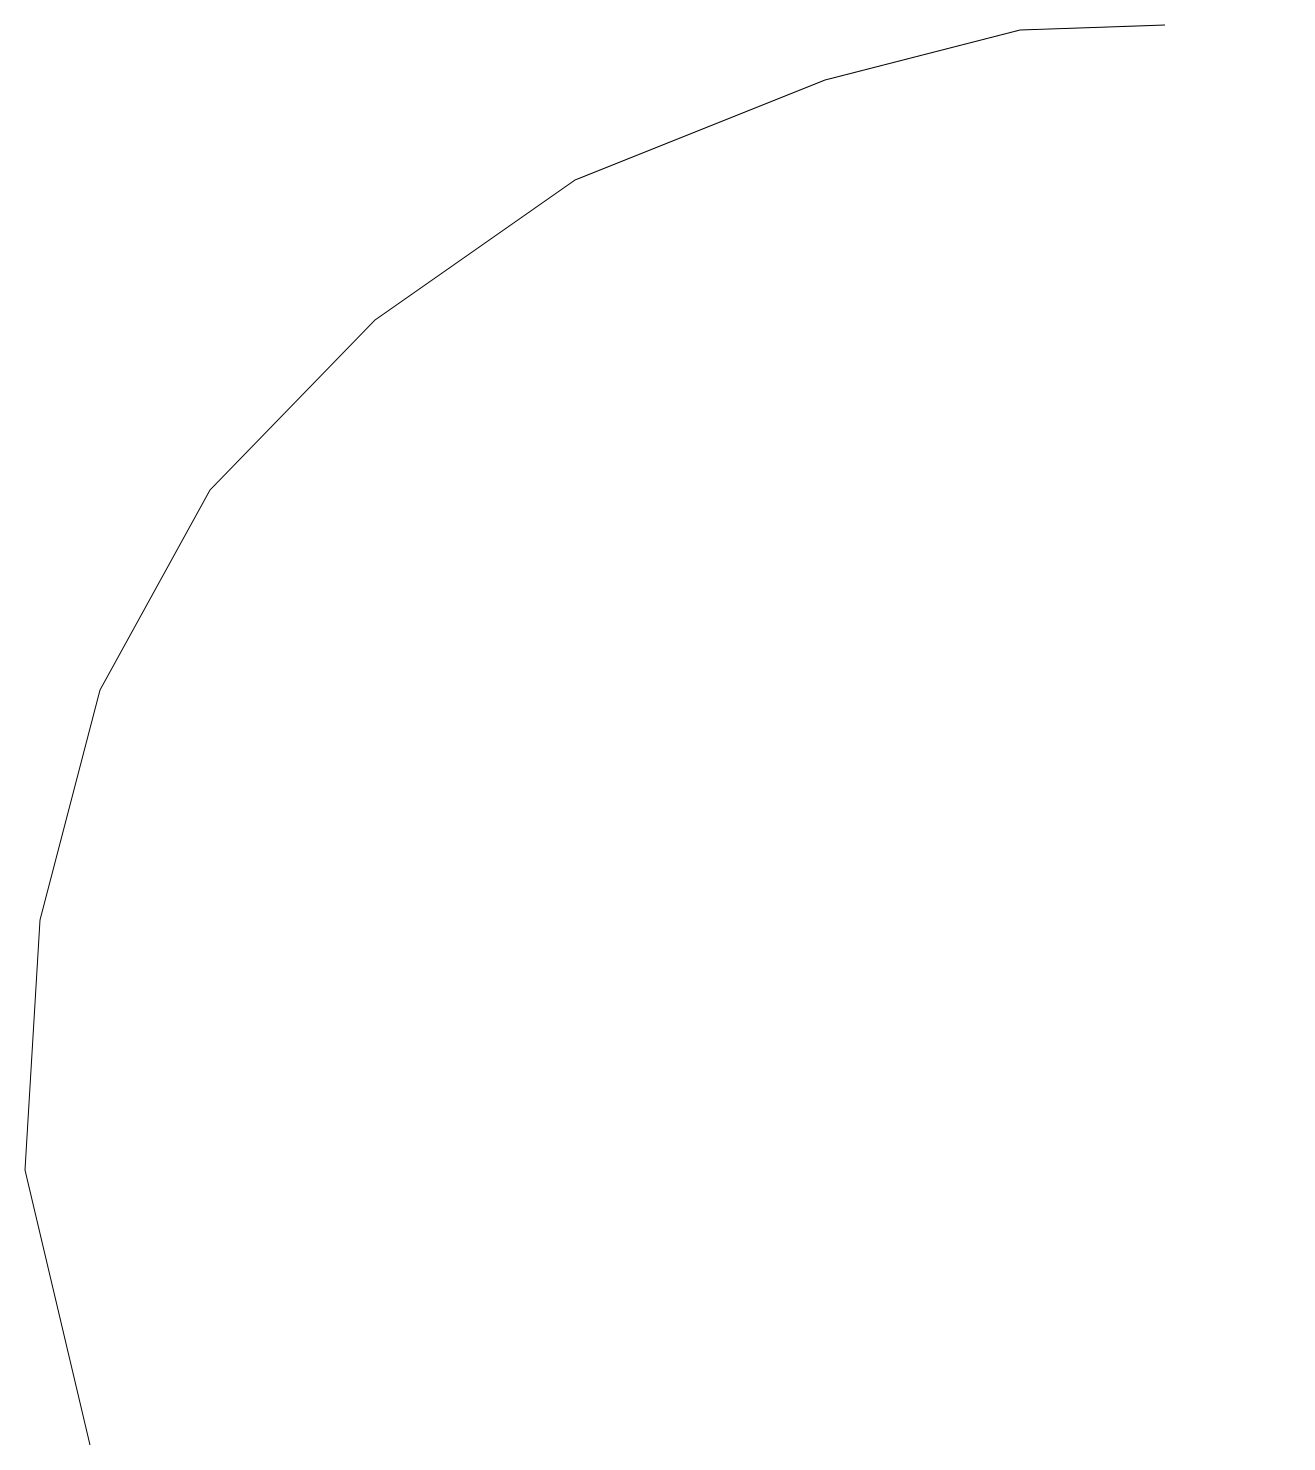

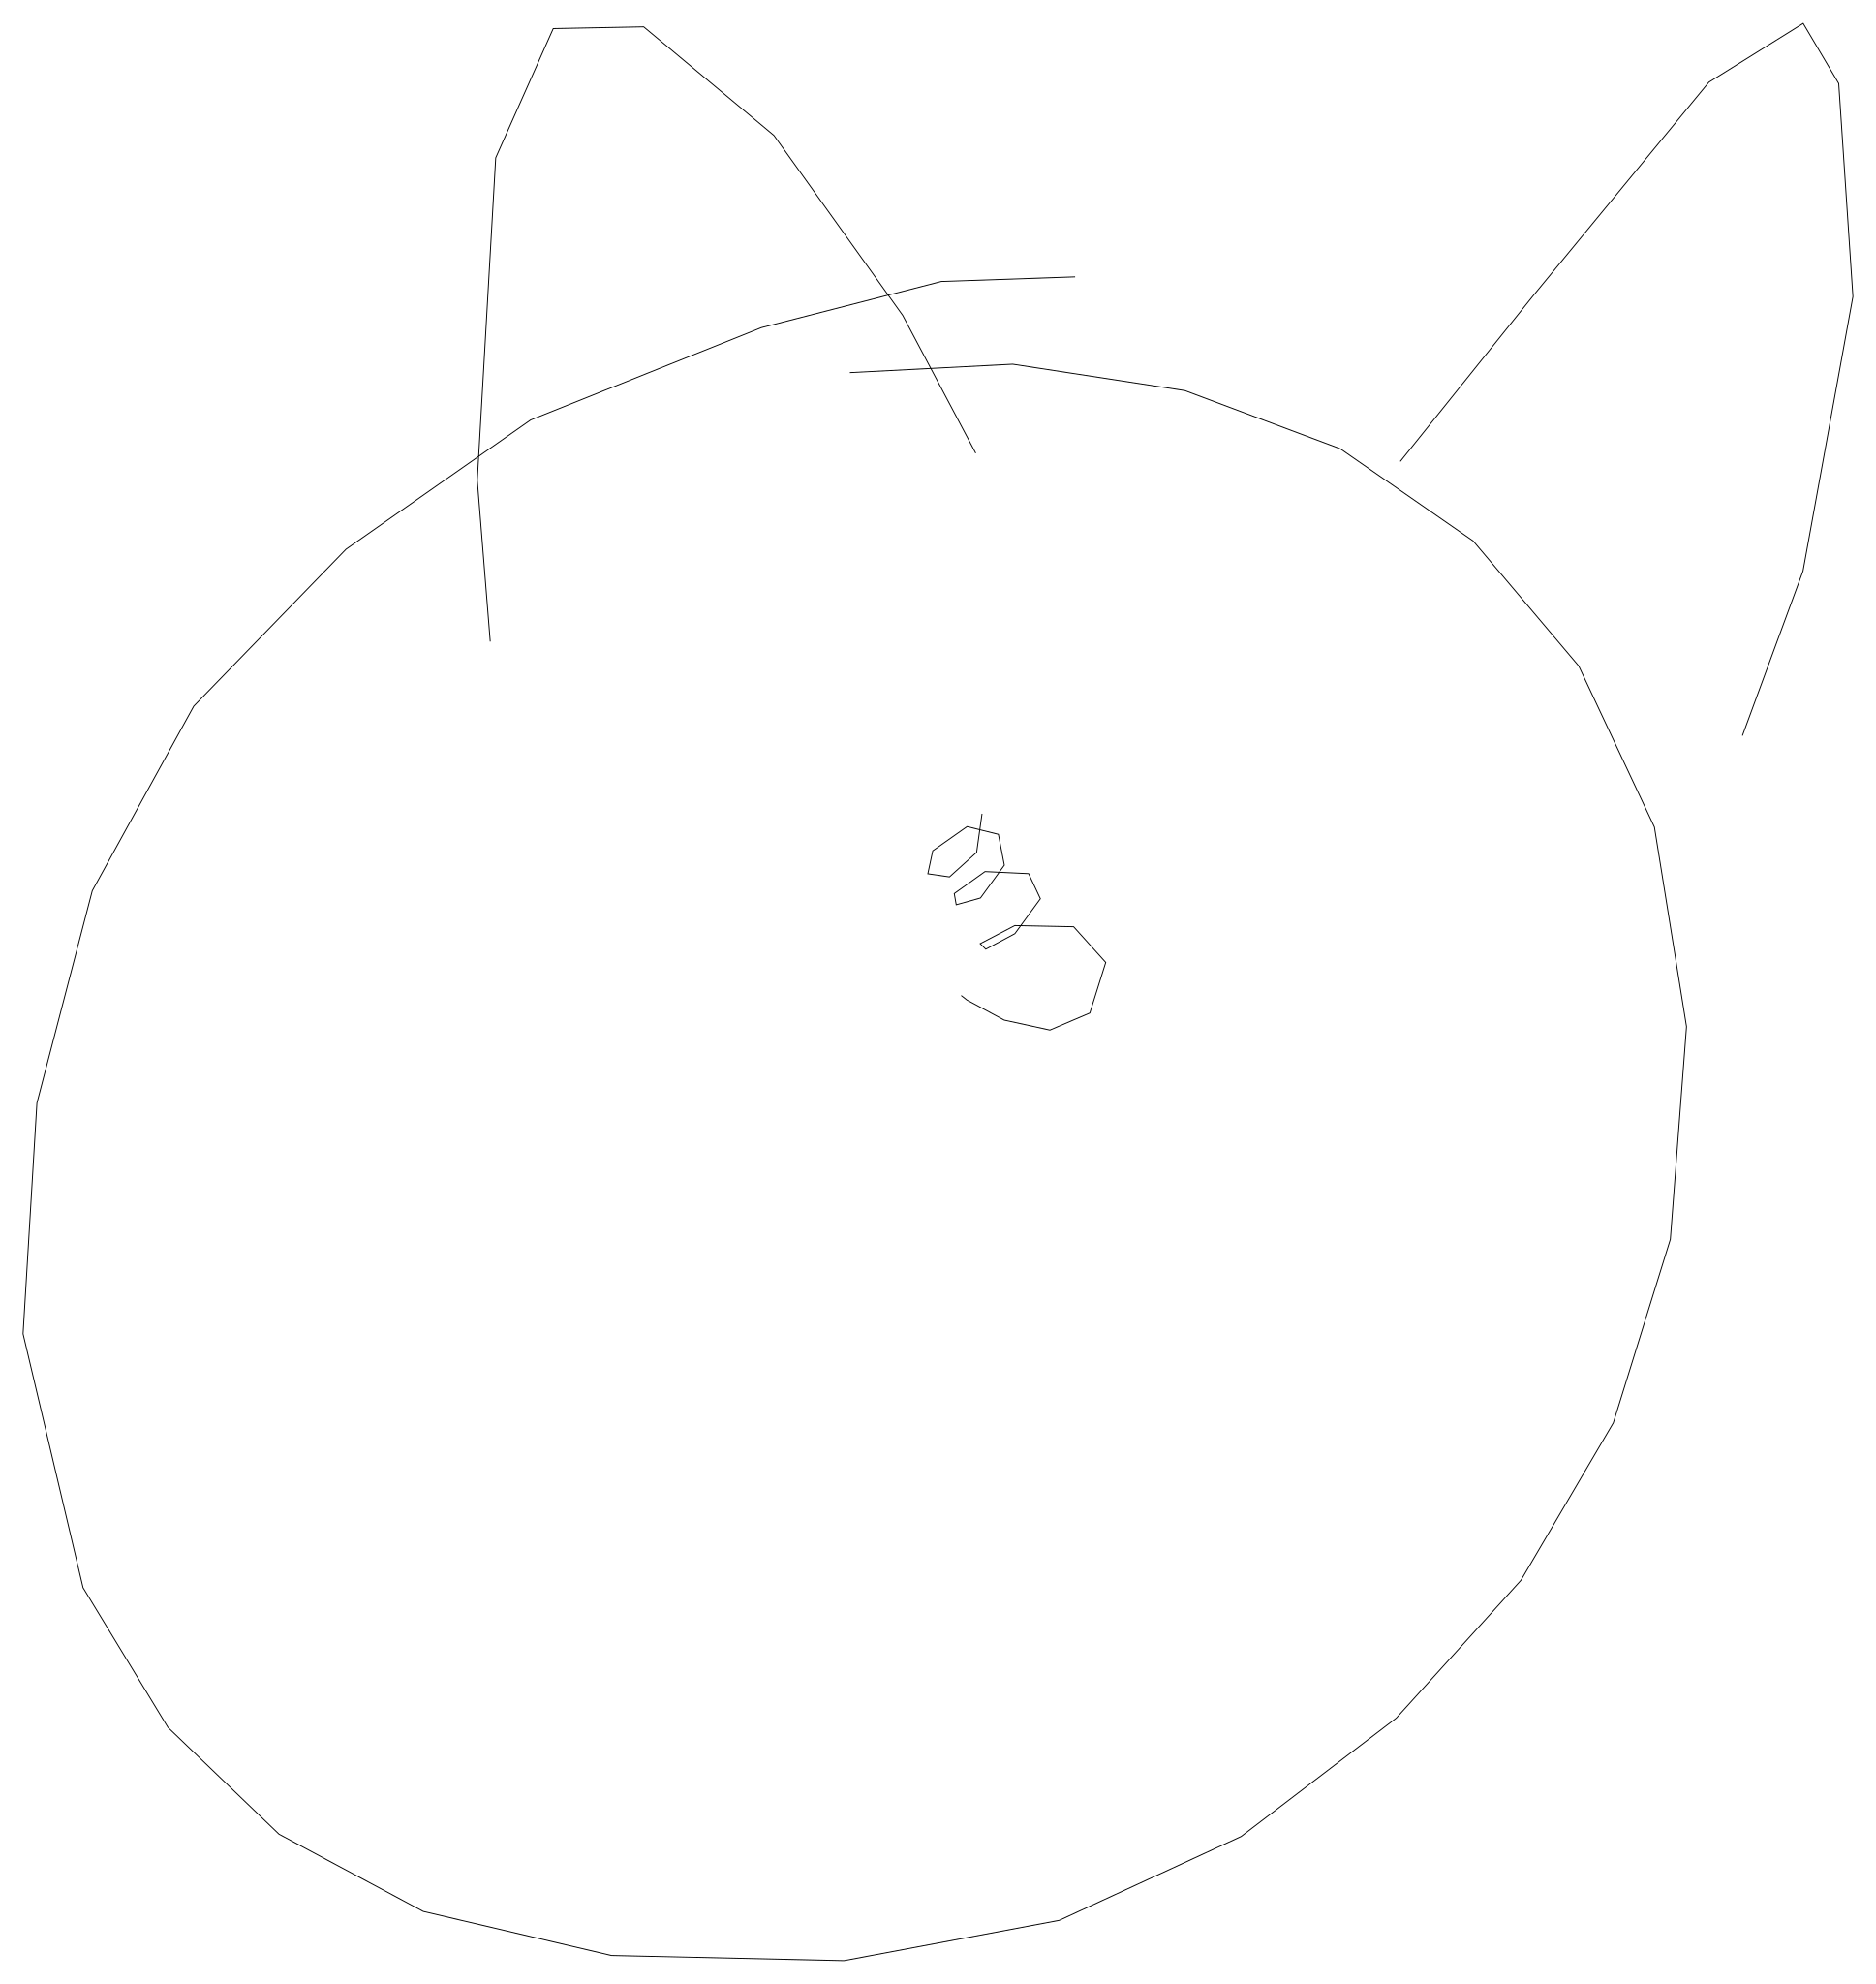

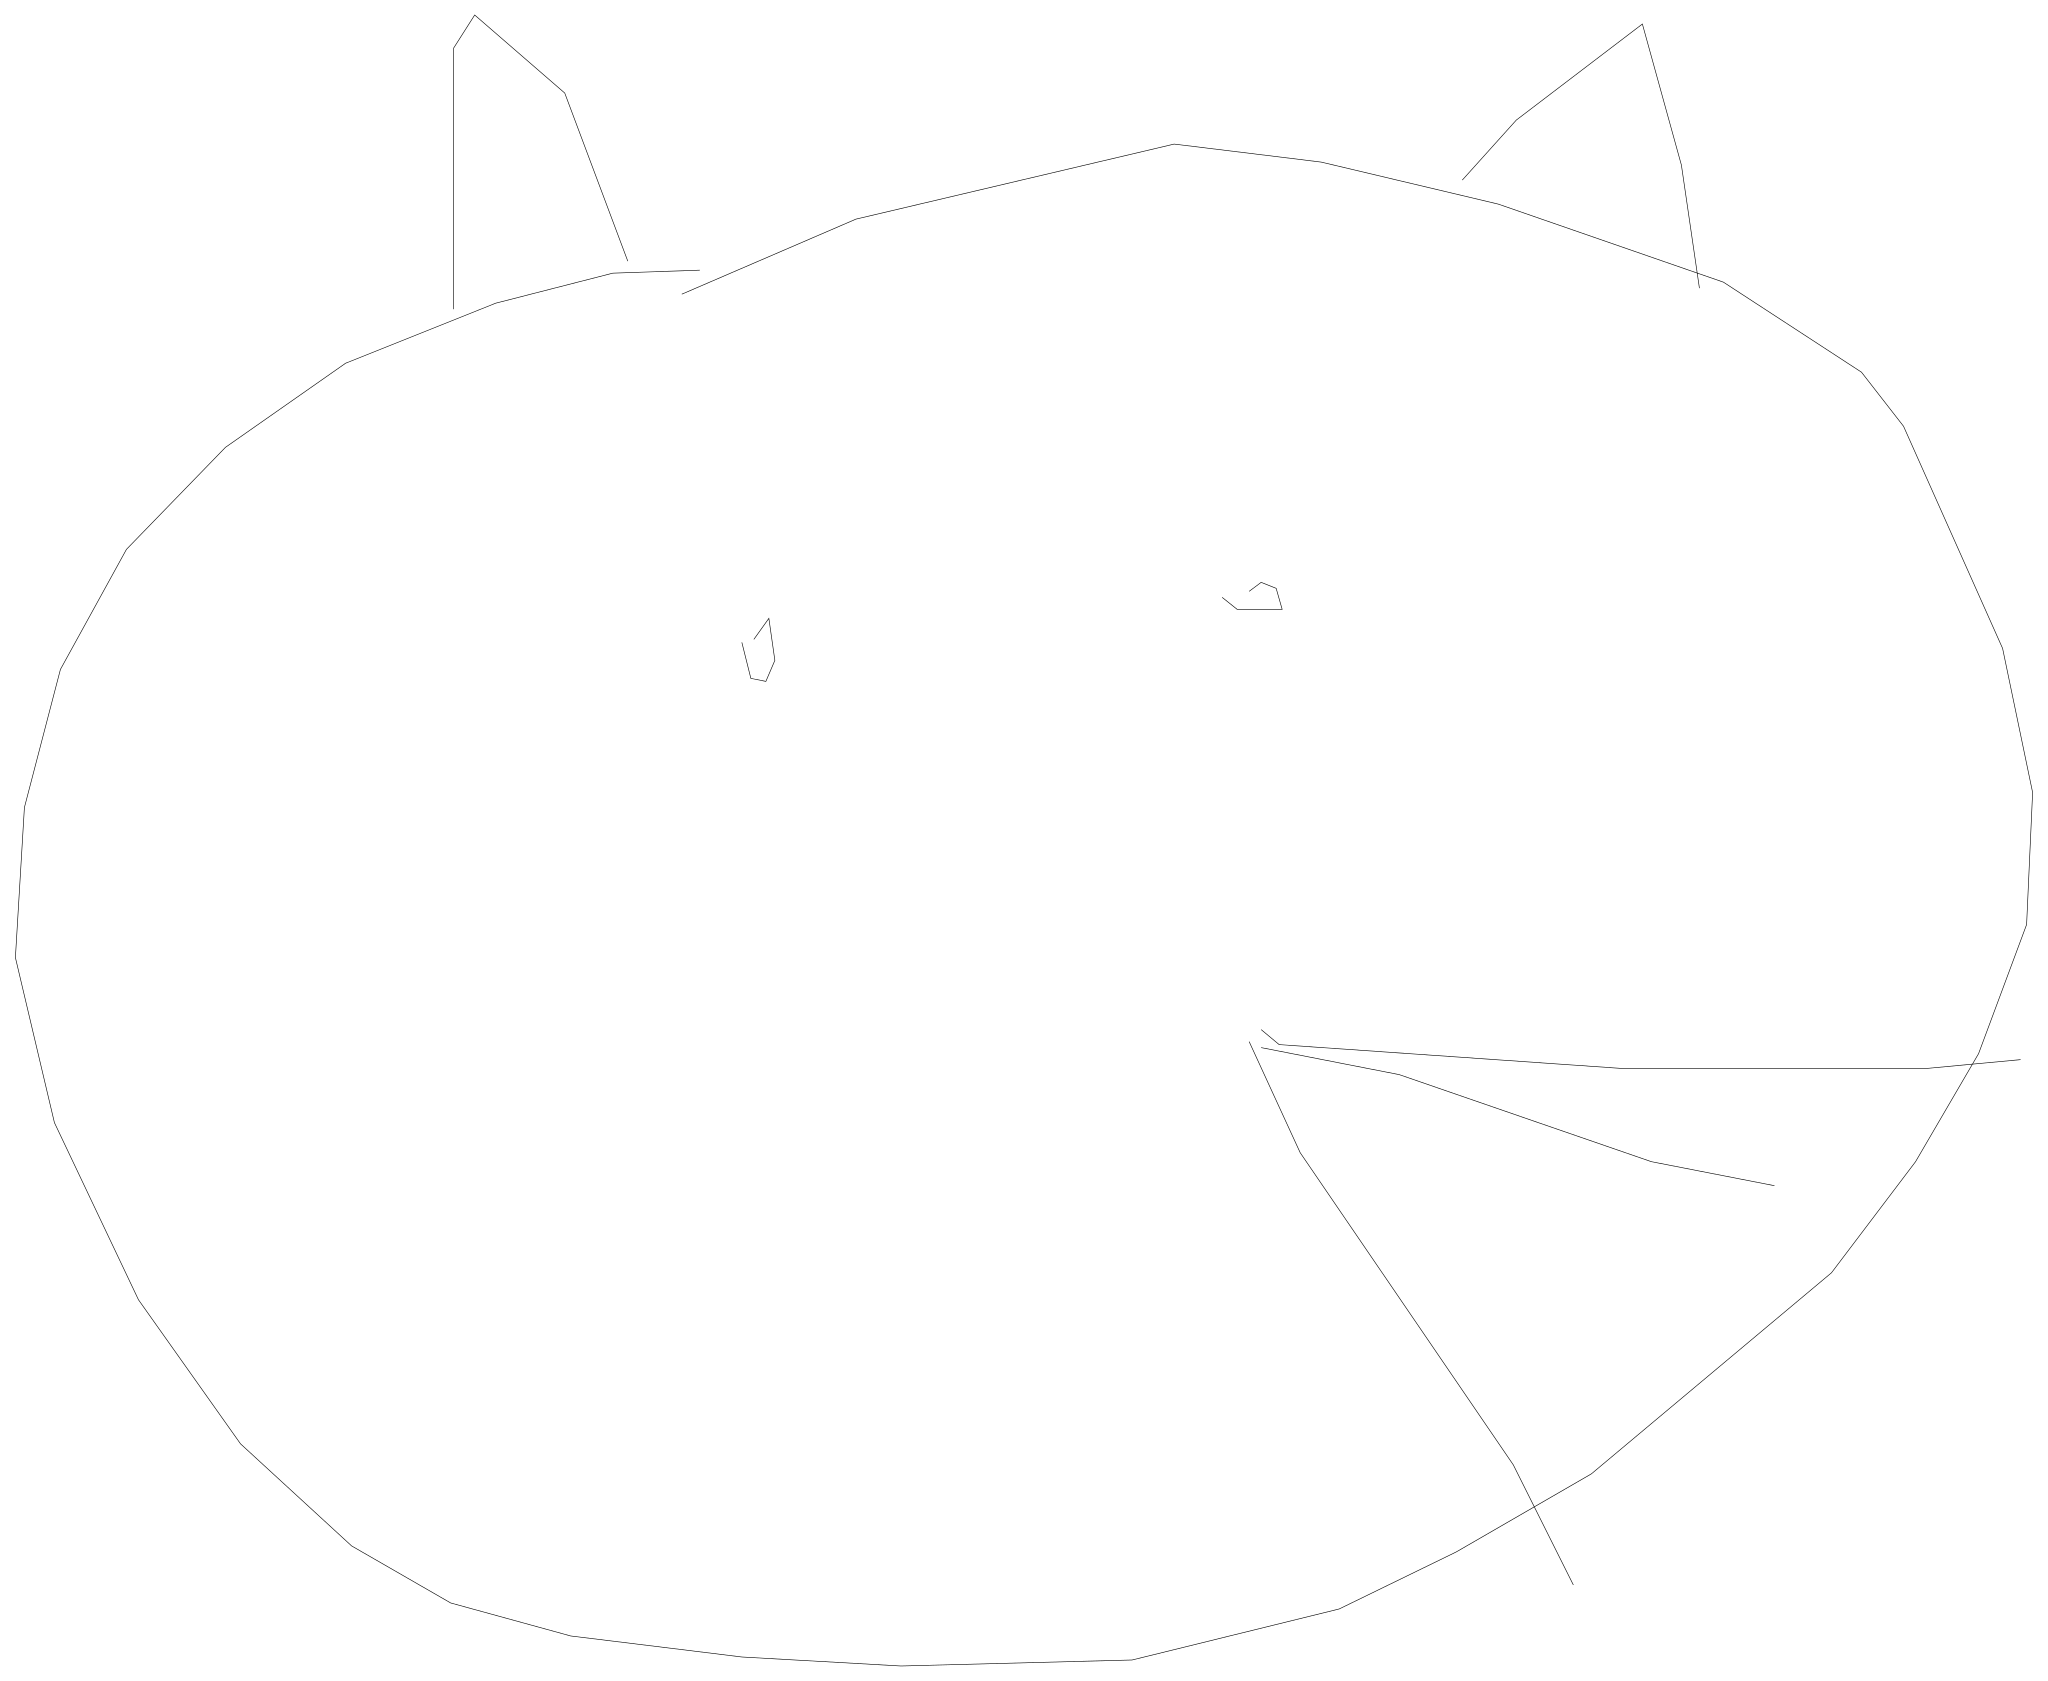

In [19]:
from utils import draw_strokes

@torch.inference_mode()
def generate(model, input_seq):
    prev = input_seq
    
    i = 0
    while i < 60:
        offset, state = model.forward(prev)
        indices = torch.argmax(state, dim=-1)
        one_hot = torch.nn.functional.one_hot(indices, 3)
        pred = torch.cat((offset, one_hot), dim=-1)
        next_seg = pred[:, -1:, :]
        prev = torch.cat((prev, next_seg), dim=1)
        i += 1
    
    return prev

strokes = train_dataset[10][0]
i = (strokes[:10]).unsqueeze(0)

output_pred = generate(model, i.to("cuda")).cpu().numpy()[0]
output_actual = strokes[:70].numpy()
draw_strokes(i[0], svg_filename='./input.svg')
draw_strokes(output_pred, svg_filename='./sample.svg')
draw_strokes(output_actual, svg_filename='./actual.svg')